In [1]:
#Loading in appropriate packages
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import json
from bs4 import BeautifulSoup
import sys
from scipy import stats
from sklearn.cross_validation import *

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

/Users/bcook/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Loading in Relevant Dataframes
master = pd.read_csv('data/lahman/Master.csv')
pitching = pd.read_csv('data/lahman/Pitching.csv')
smalldf = pd.read_csv('data/small.csv')

In [3]:
pitching.columns

Index([u'playerID', u'yearID', u'stint', u'teamID', u'lgID', u'W', u'L', u'G', u'GS', u'CG', u'SHO', u'SV', u'IPouts', u'H', u'ER', u'HR', u'BB', u'SO', u'BAOpp', u'ERA', u'IBB', u'WP', u'HBP', u'BK', u'BFP', u'GF', u'R', u'SH', u'SF', u'GIDP'], dtype='object')

For details on the Lahman file columns, see "2.3: Pitching Table": http://seanlahman.com/files/database/readme2014.txt

pitcher_sums is just the "sums", so be sure to recalculate things like ERA and BAOpp that don't add linearly

In [4]:
#Ben's intro code
retro_to_lah = dict(zip(master['retroID'], master['playerID']))
lah_to_retro = dict(zip(master['playerID'], master['retroID']))
retro_to_hand = dict(zip(master['retroID'], master['throws']))
#pitcherIDs = smalldf['pID'].unique()#RetroIDs
#L_pitcherIDs = [retro_to_lah[name] for name in pitcherIDs] #LahmanIDs
#grouped =  pitching.groupby('playerID').sum().reset_index()
#mask = np.in1d(grouped.playerID, L_pitcherIDs)
#pitcher_sums = grouped[mask]

In [5]:
smalldf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,3046,827,3425,46,609,1713,379,0.271504,0.352117,136,0.177810,0.110657,0.241460
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4582,1159,4989,47,892,1974,407,0.252946,0.313891,222,0.178793,0.081579,0.232311
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,3006,847,3357,40,582,1587,351,0.281770,0.356866,185,0.173369,0.104558,0.252309
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7561,2115,8413,102,985,3852,852,0.279725,0.352668,280,0.117081,0.101272,0.251397
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4782,1361,5339,53,666,2355,557,0.284609,0.359243,232,0.124742,0.104327,0.254917


In [6]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


#Pitchers Similarity Formula

Start with a thousand and then subtract the following:

One point for each difference of 1 win.

One point for each difference of 2 losses.

One point for each difference of .002 in winning percentage (max 100 points).

One point for each difference of .02 in ERA (max 100 points).

One point for each difference of 10 games pitched.

One point for each difference of 20 starts.

One point for each difference of 20 complete games.

One point for each difference of 50 innings pitched.

One point for each difference of 50 hits allowed.

One point for each difference of 30 strikeouts.

One point for each difference of 10 walks.

One point for each difference of 5 shutouts.

One point for each difference of 3 saves.

If they throw with a different hand and are starters subtract 10, relievers 25. For relievers you halve the winning percentage penalty. For all pitchers, the winning percentage penalty can be no larger than 1.5 times the wins and losses penalty. Relievers are defined as more relief appearances than starts and less than 4.00 innings per appearance.

We plugged all this in to create the lists you see on the player pages. Note that a player must have 100 innings pitched or 500 at bats before being considered, and to be truly accurate you need to look at whole careers, but it is fun to speculate all the same.

In [7]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [8]:
##input is the smalldf rows corresponding to the 2 pitcher ids
def pitcher_sim(p1_matchups, p2_matchups, n_common=0):
    p1name=list(p1_matchups['pID'][:1])[0]  #getting the IDs for both pitchers
    p2name=list(p2_matchups['pID'][:1])[0]
    dfhands=pd.DataFrame({'RL':[list(p1_matchups['RL'][:1])[0],list(p2_matchups['RL'][:1])[0]]}) #retrieving handedness from  smalldf
    listed= [p1name,p2name]
    two_pitcherIDs= [retro_to_lah[name] for name in listed] #getting the lahman ids for the 2 pitcher ids to use in Pitching Dataframe

    grouped2 =  pitching.groupby('playerID').sum().reset_index() #getting the summed data for each unique playerID
    mask2 = np.in1d(grouped2.playerID, two_pitcherIDs) #creating a mask for the 2 pitcher IDs needed
    pitchers=grouped2[mask2].reset_index() #resetting the index to 0,1 to make concatenating dataframes easier
    pitchers.ERA = 9.*(pitchers.ER)/(pitchers.IPouts / 3.) #generating ERA 
    pitchers.BAOpp = (pitchers.H + pitchers.BB + pitchers.IBB + pitchers.HBP) / pitchers.BFP #batting average against
    pitchers['WiP'] = pitchers.W/pitchers.G #win percentage
    pitchers['IP'] = pitchers.IPouts/3. #innings pitched
    
    #determining whether a pitcher is a relief pitcher based on whether more games started than not 
    #and less than 4 innings pitched per game
    pitchers['Games']=pitchers['GS']-pitchers['G']/2. #if positive, more games started than games in relief
    pitchers['inningsper']=pitchers['IP']/pitchers['G'] #innings per game 
    relief=[]
    for i in pitchers.iterrows():
        if i[1]['Games']<0. and i[1]['inningsper']<4.:
            relief.append(1.)
        else:
            relief.append(0.)
    dfrel=pd.DataFrame({'REL':relief})
    
    #adding handedness and whether a pitcher is a relief pitcher to the dataframe 
    final=pitchers.join([dfhands,dfrel], how='outer')
    
    #getting the 2 rows from the final dataframe to perform calculations 
    p1=final[final.playerID==two_pitcherIDs[0]]
    p2=final[final.playerID==two_pitcherIDs[1]]
    
    
    #Wins and Losses Penalties
    win_diff=np.abs(int(p1['W'])-int(p2['W'])) #1 pt for each win
    loss_diff=np.abs(int(p1['L'])-int(p2['L']))/2. #1 pt each 2 losses
    
    #Winning Percentage Penalty
    if int(p1['REL'])==1:     #winning percentage is halved for relief pitchers
        p1['WiP']=p1['WiP']/2.
    if int(p2['REL'])==1:
        p2['WiP']=p2['WiP']/2.
    wip_diff=np.abs(float(p1['WiP'])-float(p2['WiP']))/.002 #1 pt diff of winning percentage of 0.002 
    if wip_diff > 1.5*(win_diff+loss_diff): #winning percentage cannot be more than 1.5 times the penalties for win/loss differences 
        wip_diff= 1.5*(win_diff+loss_diff)
    if wip_diff >100: #penalty for winning percentage has a max= 100
        wip_diff=100   
    era_diff=np.abs(float(p1['ERA'])-float(p2['ERA']))/0.02 #1 pt diff of ERA of 0.02
    if era_diff >100:
        era_diff=100 #max =100
    
    #Handedness Penalties conditional on both pitchers being relief pitchers or not 
    if list(p1['RL'])[0]!=list(p2['RL'])[0] and int(p1['REL'])==0 and int(p2['REL'])==0: #handedness is different, relief pitchers
        hand_diff=10. 
    elif list(p1['RL'])[0]!=list(p2['RL'])[0] and int(p1['REL'])==1 and int(p2['REL'])==1.: #handedness is different, starters
        hand_diff=25.  
    else:
        hand_diff=0.
    
    #Additional Penalties
    gp_diff=np.abs(int(p1['G'])-int(p2['G']))/10. #1 pt for diff of 10 games played
    st_diff=np.abs(int(p1['GS'])-int(p2['GS']))/20. #1 pt for diff of 20 games started
    cg_diff=np.abs(int(p1['CG'])-int(p2['CG']))/20. #1 pt for diff of 20 games completed
    ip_diff=np.abs(float(p1['IP'])-float(p2['IP']))/50. #1 pt for diff of 50 innings pitched
    h_diff=np.abs(int(p1['H'])-int(p2['H']))/50. #1 pt for diff of 50 hits allowed
    so_diff=np.abs(int(p1['SO'])-int(p2['SO']))/30. #1 pt for diff of 30 strikeouts
    bb_diff=np.abs(int(p1['BB'])-int(p2['BB']))/50. #1 pt for diff of 10 walks
    sho_diff=np.abs(int(p1['SHO'])-int(p2['SHO']))/5. #1 pt for diff of 5 shutouts
    sv_diff=np.abs(int(p1['SV'])-int(p2['SV']))/3. #1 pt for diff of 3 saves
    
    score=1000 #generating starting score and subtracting penalties
    final_score=score-(win_diff+loss_diff+wip_diff+era_diff+gp_diff+st_diff+cg_diff+
                       ip_diff+h_diff+so_diff+bb_diff+sho_diff+sv_diff+hand_diff)
    #print final_score

    return final_score

In [9]:
##input is the smalldf rows corresponding to the 2 pitcher ids
def pitcher_sim_alt(p1, p2):
    #Wins and Losses Penalties
    win_diff=np.abs(int(p1['W'])-int(p2['W'])) #1 pt for each win
    loss_diff=np.abs(int(p1['L'])-int(p2['L']))/2. #1 pt each 2 losses
    
    #Winning Percentage Penalty
    if int(p1['REL'])==1:     #winning percentage is halved for relief pitchers
        p1['WiP']=p1['WiP']/2.
    if int(p2['REL'])==1:
        p2['WiP']=p2['WiP']/2.
    wip_diff=np.abs(float(p1['WiP'])-float(p2['WiP']))/.002 #1 pt diff of winning percentage of 0.002 
    if wip_diff > 1.5*(win_diff+loss_diff): #winning percentage cannot be more than 1.5 times the penalties for win/loss differences 
        wip_diff= 1.5*(win_diff+loss_diff)
    if wip_diff >100: #penalty for winning percentage has a max= 100
        wip_diff=100   
    era_diff=np.abs(float(p1['ERA'])-float(p2['ERA']))/0.02 #1 pt diff of ERA of 0.02
    if era_diff >100:
        era_diff=100 #max =100
    
    #Handedness Penalties conditional on both pitchers being relief pitchers or not 
    if p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==0 and int(p2['REL'])==0: #handedness is different, relief pitchers
        hand_diff=10. 
    elif p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==1 and int(p2['REL'])==1.: #handedness is different, starters
        hand_diff=25.  
    else:
        hand_diff=0.
    
    #Additional Penalties
    gp_diff=np.abs(int(p1['G'])-int(p2['G']))/10. #1 pt for diff of 10 games played
    st_diff=np.abs(int(p1['GS'])-int(p2['GS']))/20. #1 pt for diff of 20 games started
    cg_diff=np.abs(int(p1['CG'])-int(p2['CG']))/20. #1 pt for diff of 20 games completed
    ip_diff=np.abs(float(p1['IP'])-float(p2['IP']))/50. #1 pt for diff of 50 innings pitched
    h_diff=np.abs(int(p1['H'])-int(p2['H']))/50. #1 pt for diff of 50 hits allowed
    so_diff=np.abs(int(p1['SO'])-int(p2['SO']))/30. #1 pt for diff of 30 strikeouts
    bb_diff=np.abs(int(p1['BB'])-int(p2['BB']))/50. #1 pt for diff of 10 walks
    sho_diff=np.abs(int(p1['SHO'])-int(p2['SHO']))/5. #1 pt for diff of 5 shutouts
    sv_diff=np.abs(int(p1['SV'])-int(p2['SV']))/3. #1 pt for diff of 3 saves

    score=1000 #generating starting score and subtracting penalties
    final_score=score-(win_diff+loss_diff+wip_diff+era_diff+gp_diff+st_diff+cg_diff+
                       ip_diff+h_diff+so_diff+bb_diff+sho_diff+sv_diff+hand_diff)
    #print final_score

    return final_score

In [10]:
trainlist=np.array([])
testlist=np.array([])
validatelist=np.array([])
take=21 #21 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 150 pitchers
        train_rows, test_valid_rows = train_test_split(v.matchID.values, test_size=take)
        trainlist = np.append(trainlist,train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist =np.append(validatelist,valid_rows) 
        testlist = np.append(testlist,test_rows) 
    else:
        trainlist = np.append(trainlist,v.matchID.values)
mask = np.in1d(smalldf.matchID.values, trainlist)
traindf=smalldf[mask]
mask = np.in1d(smalldf.matchID.values, validatelist)
validatedf=smalldf[mask]
mask = np.in1d(smalldf.matchID.values, testlist)
testdf=smalldf[mask]
print traindf.shape, validatedf.shape, testdf.shape

(101036, 39) (4944, 39) (3708, 39)


In [11]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['bID', 'pID','AVG']]
testdf=testdf[['bID', 'pID', 'AVG']]
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2872,780,3227,42,574,1635,355,0.271588,0.351720,125,0.177874,0.110009,0.241711
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4174,1051,4547,41,805,1771,373,0.251797,0.313174,204,0.177040,0.082032,0.231141
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2832,802,3165,36,552,1504,333,0.283192,0.358610,176,0.174408,0.105213,0.253397
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7255,2027,8086,100,947,3701,831,0.279394,0.353450,265,0.117116,0.102770,0.250680
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4634,1327,5175,52,643,2291,541,0.286362,0.360966,221,0.124251,0.104541,0.256425


In [12]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [13]:
def get_pitching_totals(pitching_df, upids):
    lah_pitchers = [retro_to_lah[name] for name in upids]
    pitching_totals = pitching.groupby('playerID').sum().reset_index()
    pitching_totals = pitching_totals[np.in1d(pitching_totals['playerID'], lah_pitchers)]
    pitching_totals.head()
    pitching_totals['BB_total'] = pitching_totals['BB'] + pitching_totals['IBB'] + pitching_totals['HBP']
    pitching_totals['pID'] = [lah_to_retro[name] for name in pitching_totals.playerID]
    pitching_totals['RL'] = [retro_to_hand[name] for name in pitching_totals.pID]
    pitching_totals['IP'] = pitching_totals['IPouts']/3.
    pitching_totals['Games']=pitching_totals['GS']-pitching_totals['G']/2. #if positive, more games started than games in relief
    pitching_totals['inningsper']=pitching_totals['IP']/pitching_totals['G'] #innings per game 
    relief=[1 if (i[1]['Games'] < 0. and i[1]['inningsper']<4.) else 0 for i in pitching_totals.iterrows()]
    pitching_totals['REL'] = relief
    pitching_totals['ERA'] = pitching_totals['ER'] *9. / (pitching_totals['IP'])
    pitching_totals['BAOpp'] = (pitching_totals.H + pitching_totals.BB_total) / pitching_totals.BFP #batting average against
    pitching_totals['WiP'] = pitching_totals.W/pitching_totals.G #win percentage

    return pitching_totals[['pID', 'W', 'L', 'ERA', 'RL', 'BAOpp', 'WiP', 'IP', 'REL', 'G', 'GS', 'CG', 'H', 'SO', 'BB', 'SHO', 'SV']]

In [14]:
pitching_totals = get_pitching_totals(pitching, upids)

In [15]:
# %%time
# for i in np.arange(1e3):
#     p1, p2 = np.random.choice(pitching_totals.pID.values, size=2)
#     pitcher_sim_alt(pitching_totals[pitching_totals.pID==p1], pitching_totals[pitching_totals.pID==p2])

In [16]:
class Database_pitch:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.inversemap = dict(zip(self.rindexmap.values(), self.rindexmap.keys()))
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        return sim

In [17]:
db=Database_pitch(upidmap)

In [18]:
def populate_by_calculating(db, df, similarity_func):
    """
    a populator for every pair of businesses in df. takes similarity_func like
    pearson_sim as argument
    """
    items=db.rindexmap.items()
    start = time.time()
    count = 0
    total = len(items)**2

    for p1, i1 in items:
        for p2, i2 in items:
            count += 1
            if (((100*count)/total) > ((100*(count-1))/total)):
                frac_done = (count+1)/float(total)
                time_elapsed = (time.time() - start) / (60.)
                remaining = ((1./frac_done)-1.)*time_elapsed
                print('%.1f percent done | elapsed: %.1f min | remaining: %.2f hour'%(frac_done *100, time_elapsed, remaining/60))
            if i1 <= i2:
                p1_row = df[df.pID==p1]
                p2_row = df[df.pID==p2]
                sim =similarity_func(p1_row, p2_row)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim

In [19]:
# %%time
# populate_by_calculating(db, pitching_totals, pitcher_sim_alt)  

In [20]:
import cPickle as pickle
# pickle.dump(db,open('pitching_db.p','wb'))
db = pickle.load(open('pitching_db.p','rb'))

In [21]:
db.database_sim

array([[ 1000.        ,   822.14444154,   809.87820524, ...,
          392.72806057,   406.97872884,   362.19      ],
       [  822.14444154,  1000.        ,   635.96314377, ...,
          259.43      ,   264.84666667,   244.32333333],
       [  809.87820524,   635.96314377,  1000.        , ...,
          530.43596644,   520.6351442 ,   473.23369732],
       ..., 
       [  392.72806057,   259.43      ,   530.43596644, ...,
         1000.        ,   943.89933173,   944.16769803],
       [  406.97872884,   264.84666667,   520.6351442 , ...,
          943.89933173,  1000.        ,   894.26702976],
       [  362.19      ,   244.32333333,   473.23369732, ...,
          944.16769803,   894.26702976,  1000.        ]])

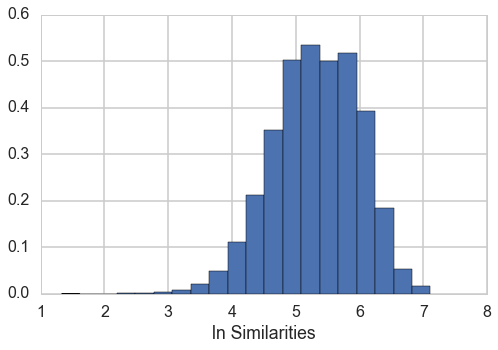

In [26]:
fig, axis = plt.subplots(figsize=(8,5))
sims = np.log(1000.-db.database_sim.flatten())
axis.hist(sims[sims>=0], bins=20, normed=True)
axis.set_xlabel('ln Similarities')

In [27]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [28]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the set of restaurants.
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_rest_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [29]:
def get_users_restaurants(df, b_id):
    dfbatter=df[df.bID==b_id]
    dfbatterdedup=dfbatter.drop_duplicates('pID')
    return dict(zip(dfbatterdedup.pID.values, dfbatterdedup.AVG.values))

In [30]:
"""
Function
--------
rating

Parameters
----------
set_of_restaurants: Dictionary
    The dictionary of restaurant: star-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_restaurants
train_map: Dictionary
    A dictionary with keys mean, users and items which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for restaurant_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
#your code here
# Note: this function was inspired in part by the solutions to the 2013 hw4
def rating(set_of_restaurants, train_map, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=train_map['mean']
    user_bias = train_map['batters'][user_id]
    nsum=0.
    scoresum=0.
    nears=knearest(restaurant_id, set_of_restaurants, dbase, k=k, reg=reg)
    restaurant_bias=train_map['pitchers'][restaurant_id]
    scores=[]
    for r,s,nc in nears:
        ssim = 1-s
        scoresum=scoresum+ssim
        scores.append(ssim)
        r_biases = train_map['pitchers'][r]
        r_stars = set_of_restaurants[r]
        rminusb=(r_stars - (r_biases + user_bias + mu))
        nsum=nsum+ssim*rminusb
    baseline=(user_bias +restaurant_bias + mu)
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

In [31]:
trainuser=traindf.loc[100].bID
try:
    testrest=testdf[testdf.bID==trainuser].pID.values[0]
except:
    testrest=testdf[testdf.bID==trainuser].pID
print trainuser, testrest

willj004 armat002


In [32]:
testdf[testdf.bID=='abreb001'].pID.values

array(['beavb001', 'blacn001', 'gintm001', 'lines001', 'penat003',
       'perkg001', 'shawj001', 'sherg001', 'walld002'], dtype=object)

In [33]:
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2872,780,3227,42,574,1635,355,0.271588,0.351720,125,0.177874,0.110009,0.241711
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4174,1051,4547,41,805,1771,373,0.251797,0.313174,204,0.177040,0.082032,0.231141
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2832,802,3165,36,552,1504,333,0.283192,0.358610,176,0.174408,0.105213,0.253397
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7255,2027,8086,100,947,3701,831,0.279394,0.353450,265,0.117116,0.102770,0.250680
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4634,1327,5175,52,643,2291,541,0.286362,0.360966,221,0.124251,0.104541,0.256425


In [34]:
def get_actual(df, userid, bizid):
    return df[(df.bID==userid) & (df.pID==bizid)]['AVG'].values[0]

In [35]:
print "Actual", get_actual(testdf, trainuser, testrest)
print "Predicted",rating(get_users_restaurants(traindf, trainuser), train_avgs, db, testrest, trainuser, k=2, reg=3.)

Actual 0.375
Predicted

NameError: name 'train_avgs' is not defined

In [ ]:
def get_ratings_user_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.pID, indf.bID, indf.AVG)
    preds=[]
    actuals=[]
    for (r,u,actual) in zips:
        pred=rating(get_users_restaurants(traindf, u),train_map, db, r,u, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

In [ ]:
%%time
pt, at = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=6, reg=4.)
compare_results(at,pt, model="knn(user) on training k=6, reg=4", predicteds=True)

In [ ]:
%%time
k = range(40,100,10)
reg = range(1,12,2)
rmsedict = {}
for kval in k:
    for regval in reg:
        pt, at = get_ratings_user_nbd(validatedf, traindf, train_avgs, db, k=kval, reg=regval)
        rmse = get_rmse(at, pt)
        key = (kval, regval)
        rmsedict[key] = rmse
   

In [ ]:
     
mintup=min(rmsedict, key=rmsedict.get)
mintup

In [ ]:
bestk, bestreg = mintup
predictions["knn"], atknn = get_ratings_user_nbd(testdf, traindf,train_avgs, db, k=bestk, reg=bestreg)
predictions_valid["knn"], atvalid = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=bestk, reg=bestreg)

In [ ]:
ax, rmse_knn = compare_results(testdf.AVG, predictions['knn'], model=("knn(user) on test k=" + str(bestk) + ", reg=" + str(bestreg)), predicteds=True)
# compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True, onsame=ax)